# 机器学习在企业风险管理中的应用举例

## 准备工作

### 读取数据并引入我们需要用到的包

我们重点是去了解机器学习，因而我对于数据背后的经济原理和风险因素并不是非常关注，每个符号代表什么详见 [笔记](https://ernestdong.github.io/posts/machine_learning_in_erm/)
```shell
pip install -r requirements.txt
```

有 Nvidia GPU 的同学可以参考 [pytorch 官网](https://pytorch.org/) 利用 cuda 加速神经网络（通常能有10来倍吧），CPU 在神经网络部分稍慢一些不过也可以实现

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("../input/corporate-credit-rating/corporate_rating.csv", encoding="utf-8")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029 non-null   float64
 11  pretaxProfitMargin                  2029 no

### 看一下评级的分布

<AxesSubplot:>

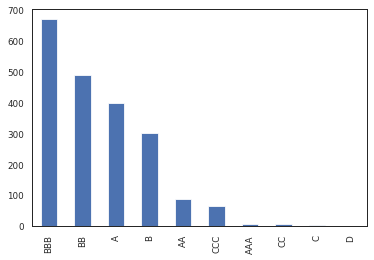

In [2]:
sns.set(
    style="white",
    context="paper",
    rc={"text.usetex": False},
)
df["Rating"].value_counts().plot(kind="bar")


### 其他准备
- 设置随机数种子保证多次运行结果一致
- 把非数字的变量转换成虚拟变量
- 设置训练集和测试集

In [3]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
Y = df["Rating"]
Y = Y.replace({"CCC": "C", "CC": "C"})
df["Date"] = df["Date"].apply(lambda x: x.split("/")[-1])
dummies = ["Rating Agency Name", "Sector", "Date"]
X = df[[i for i in df.columns if df[i].dtype != "object"]]
for dummy in dummies:
    X = pd.concat([X, pd.get_dummies(df[dummy], drop_first=True, prefix=dummy)], axis=1)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.25, random_state=RANDOM_STATE
)
result = {}
X.columns


Index(['currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding',
       'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed',
       'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover',
       'debtEquityRatio', 'debtRatio', 'effectiveTaxRate',
       'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare',
       'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue',
       'enterpriseValueMultiple', 'operatingCashFlowPerShare',
       'operatingCashFlowSalesRatio', 'payablesTurnover',
       'Rating Agency Name_Egan-Jones Ratings Company',
       'Rating Agency Name_Fitch Ratings',
       'Rating Agency Name_Moody's Investors Service',
       'Rating Agency Name_Standard & Poor's Ratings Services',
       'Sector_Capital Goods', 'Sector_Consumer Durables',
       'Sector_Consumer Non-Durables', 'Sector_Consumer Services',
       'Sector_Energy', 'Sector_Finance', 'Sector_Hea

### 评价指标

我们用评级的准确率、召回率和 $F1$ 值作为评级是否准确的指标，也关注偏差是否特别大（用所谓的“相关系数”衡量）

作为对比，如果我们训练的分类器没什么效果，那么和这里随机瞎选的评级的准确率应该差不多

In [4]:
def get_score(Xtest, Ytrue, model):
    Ypred = model(Xtest)
    average = "weighted"
    rating_map = {i: ord(i[0]) * 100 - len(i) for i in Y.unique()}
    return {
        "precision": precision_score(Ytrue, Ypred, average=average, zero_division=0),
        "recall": recall_score(Ytrue, Ypred, average=average),
        "f1": f1_score(Ytrue, Ypred, average=average),
        "\(R^2\)": pearsonr(
            [rating_map[i] for i in Ypred], [rating_map[i] for i in Ytest]
        )[0],
    }


random.seed(RANDOM_STATE)
ratings = Y.unique()
tmp = {}
monte_num = 100
for i in range(100):
    Ypredict = Xtest.index.map(lambda x: random.choice(ratings))
    monte = get_score(Xtest, Ytest, lambda _: Ypredict)
    for j in monte:
        if j not in tmp:
            tmp[j] = 0
        tmp[j] += monte[j]
result["random"] = {i: tmp[i] / 100 for i in tmp}
result["random"]


{'precision': 0.23640721599080028,
 'recall': 0.12547244094488194,
 'f1': 0.1544436285781241,
 '\\(R^2\\)': 0.008907176874420716}

## `sklearn` 部分
`sklearn` 里面的分类器语法非常简单，就是声明分类器是什么、我去训练他，比如 `ols` 模型

```python
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
model = LinearRegression()
result = model.fit(X, y) 
result.coef_ # 系数
```
### logit 回归

In [5]:
logit = LogisticRegression(
    multi_class="multinomial", solver="saga", random_state=RANDOM_STATE
)
logit.fit(Xtrain, Ytrain)
result["logit"] = get_score(Xtest, Ytest, logit.predict)
result["logit"]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


{'precision': 0.18152641834788635,
 'recall': 0.2440944881889764,
 'f1': 0.15470492292394605,
 '\\(R^2\\)': -0.017753356860605723}

### 决策树

In [6]:
dt = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
dt.fit(Xtrain, Ytrain)
result["decision tree"] = get_score(Xtest, Ytest, dt.predict)
result["decision tree"]


{'precision': 0.3498883972871522,
 'recall': 0.3799212598425197,
 'f1': 0.3528756642882673,
 '\\(R^2\\)': 0.3632276367156314}

### 集成学习

#### bagging 方法的随机森林

In [7]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_STATE)
rf.fit(Xtrain, Ytrain)
result["random forest"] = get_score(Xtest, Ytest, rf.predict)
result["random forest"]


{'precision': 0.39603489727136376,
 'recall': 0.4251968503937008,
 'f1': 0.38351839772007446,
 '\\(R^2\\)': 0.3995913974193085}

### boosting 方法的梯度提升数
最流行的应当是 `xgboost` ，但是 `sklearn` 里面没有现场的，为了教学简单我们用 `sklearn` 里面提供的 boosting 方法的模型

In [8]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb.fit(Xtrain, Ytrain)
result["gradient boosting"] = get_score(Xtest, Ytest, gb.predict)
result["gradient boosting"]


{'precision': 0.530520009176101,
 'recall': 0.5255905511811023,
 'f1': 0.5094674767985568,
 '\\(R^2\\)': 0.5421094375792002}

### 支持向量机

In [9]:
svm = SVC(kernel="rbf", gamma="auto", random_state=RANDOM_STATE)
svm.fit(Xtrain, Ytrain)
result["svm"] = get_score(Xtest, Ytest, svm.predict)
result["svm"]


{'precision': 0.4136927083234441,
 'recall': 0.4094488188976378,
 'f1': 0.351708147106921,
 '\\(R^2\\)': 0.3431290118925812}

### K 近邻

In [10]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(Xtrain, Ytrain)
result["KNN"] = get_score(Xtest, Ytest, KNN.predict)
result["KNN"]


{'precision': 0.3625400456087721,
 'recall': 0.35236220472440943,
 'f1': 0.34202311550427716,
 '\\(R^2\\)': 0.2987378286522417}

## 深度学习

深度学习技术特点是利用神经网络， `pytorch` 是最流行的框架，稳定、简单……，只需要继承 `nn.module` 并告诉他传播是如何传播的， `pytorch` 就能帮我们自动建图求导

世界上的东西总有关系，函数可以描述，但是我们不知道函数长什么样子，深度学习受到生物神经的启发，构建一层层网络，让神经网络去拟合这个函数
### 何谓梯度下降/反向传播

我们以线性回归为例子，了解一下梯度下降和误差反向传播是如何发挥作用的。

梯度的定义是 $(\frac{\partial{f}}{\partial{x}}i, \frac{\partial{f}}{\partial{y}}j)$，沿着梯度向下最大的方向走一小步，我们离 “最优” 更近一点


In [11]:
x = torch.rand([500, 1])  # X 是一个 tensor ，可以把他想象成 500x1 的向量
y_true = 3 * x + 8
learning_rate = 0.05  # learning rate 是每次梯度下降的“步长”
w = torch.rand([1, 1], requires_grad=True)  # 斜率 w 和截距 b 我们要 pytorch 自动求导
b = torch.tensor(0, requires_grad=True, dtype=torch.float32)
for i in range(500): # 迭代 500 次
    y_pred = torch.matmul(x, w) + b  # 预测是多少
    loss = (y_true - y_pred).pow(2).mean()  # 损失函数是平方误差
    if w.grad is not None:  # 把上一次的计算的梯度清零，否则梯度会不断累加
        w.grad.data.zero_()
    if b.grad is not None:
        b.grad.data.zero_()
    loss.backward()  # 误差反向传播，得到 w 和 b 的梯度 w.grad 和 b.grad
    w.data = w.data - w.grad * learning_rate  # 梯度下降找到新的 w 和 b
    b.data = b.data - b.grad * learning_rate
    if i % 50 == 0:
        print(w.item(), b.item(), loss.item())


0.8421722650527954 0.925064742565155 86.14746856689453
3.8227314949035645 7.568560600280762 0.05878502503037453
3.5908188819885254 7.697819232940674 0.029924962669610977
3.4220690727233887 7.784137725830078 0.015271581709384918
3.301514148712158 7.845794200897217 0.00779349310323596
3.215393543243408 7.8898396492004395 0.0039772395975887775
3.1538708209991455 7.921304702758789 0.0020296864677220583
3.10992169380188 7.943781852722168 0.0010358194122090936
3.0785253047943115 7.959839344024658 0.0005286113009788096
3.0560965538024902 7.971310138702393 0.0002697656746022403


### 多层感知机

如果仅仅是线性函数的叠加，那么输出还是线性的。神经元受刺激必须到达阈值才会输出，模仿就是 “激活函数”

一层神经元受到刺激得到一个输出，我们再让这些输出给到下一层神经元，就构建了一层神经网络

In [12]:
Ytrain_nn = pd.get_dummies(Ytrain)
encode = Ytrain_nn.columns
Ytrain_nn = torch.tensor(Ytrain_nn.values, dtype=torch.float32).to(device)
Xtrain_nn = torch.tensor(Xtrain.values, dtype=torch.float32).to(device)

hidden_layer = 40
net = nn.Sequential(
    nn.Linear(Xtrain_nn.shape[1], hidden_layer),
    nn.ReLU(),
    nn.Linear(hidden_layer, len(encode)),
    nn.Softmax(dim=1),
).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

for t in range(10000):
    prediction = net(Xtrain_nn)
    loss = loss_func(Ytrain_nn, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
Xtest_nn = torch.tensor(Xtest.values, dtype=torch.float32).to(device)
prediction = net(Xtest_nn).cpu()
prediction = pd.DataFrame(prediction.detach().numpy())
Ypredict = prediction.idxmax(axis=1).map(lambda x: encode[x])
result["bp neural network"] = get_score(Xtest, Ytest, lambda _: Ypredict)
result["bp neural network"]


{'precision': 0.2781330018577855,
 'recall': 0.32086614173228345,
 'f1': 0.2791265241802535,
 '\\(R^2\\)': -0.01689758835042282}

### 卷积神经网络

反向传播的 bp 神经网络很早就被提出来了，但应用结果并不好，人工智能发展也进入了低潮期。即便人脑是如何学习的，生物学家至今仍搞不清楚。

我们看一张图片，一眼扫过去不会记住每个点是什么，而是会记住大概什么位置这片区域是个什么。基于此，“卷积神经网络”应运而生。

利用一个卷积核扫描过去，得到一层“特征”。多次重复后，对特征开展学习，会不会好一些？

下面的代码就是利用 20 个大小为 3 的卷积核扫描，通过激活函数后“池化”（取两个相邻位置的平均值）避免过拟合，最后一层全连接层将卷积运算后的结果输出到 7 个评级上面。

In [13]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(Xtrain_nn.shape[1], 20, 3,padding=2),
            nn.Tanh(),
            nn.AvgPool1d(3),
        )
        self.fc = nn.Sequential(
            nn.Linear(20, len(encode)),
            nn.ReLU(),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


net = CNN().to(device)
optimizer = torch.optim.Adamax(net.parameters(),lr=0.0025)
loss_func = torch.nn.L1Loss()
epochnum = 30000
for epoch in range(epochnum):
    prediction = net(Xtrain_nn.unsqueeze(2))
    loss = loss_func(Ytrain_nn, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % (epochnum / 10) == 0:
        print("epoch:", epoch, "loss:", loss.item())
prediction = net(Xtest_nn.unsqueeze(2)).cpu()
prediction = pd.DataFrame(prediction.detach().numpy())
Ypredict = prediction.idxmax(axis=1).map(lambda x: encode[x])
result["CNN"] = get_score(Xtest, Ytest, lambda _: Ypredict)
result["CNN"]

epoch: 0 loss: 0.24471411108970642
epoch: 3000 loss: 0.059977807104587555
epoch: 6000 loss: 0.044818051159381866
epoch: 9000 loss: 0.04058485105633736
epoch: 12000 loss: 0.038132742047309875
epoch: 15000 loss: 0.03712695464491844
epoch: 18000 loss: 0.03663425147533417
epoch: 21000 loss: 0.03562198579311371
epoch: 24000 loss: 0.034744344651699066
epoch: 27000 loss: 0.034025199711322784


{'precision': 0.4112058531042291,
 'recall': 0.4468503937007874,
 'f1': 0.42582561477597597,
 '\\(R^2\\)': 0.40228307270670977}

### 循环神经网络

CNN 广泛运用在计算机视觉领域，但是准确率其实也一般。至于自然语言处理，卷积扫描过去只会记住附近长什么样子，缺乏长期记忆。

比如 I am Chinese. I am learning enterprise risk management and machine learning. I speak Chinese. 
只记住附近的数据显然在翻译第三句话的时候对 Chinese 翻译没有用到之前的信息。

RNN 则是通过权值共享解决记忆问题，不再是一层层神经网络，而是一个神经元接受输入，输出再进入到这个神经元并进行更新，如图所示。

![](https://pic1.zhimg.com/80/v2-ea6d9bcb018d897518a8f076e7f9fdcc_1440w.jpg)

这样的话求导（一个神经元求一次导在系数上加一次，如 $x^n$ 变 $nx^{n-1}$，循环好多好多次）很容易梯度爆炸或者梯度离散，我用传统的 RNN 拟合并没有好一些，于是采用了 RNN 加强版“长短期记忆”模型

In [14]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=48,
            hidden_size=100,
            batch_first=True,
        )
        self.fc = nn.Sequential(
            nn.Linear(100, len(encode)),
            nn.ReLU(),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

net = RNN().to(device)
optimizer = torch.optim.Adamax(net.parameters())
loss_func = nn.MSELoss()
epochnum = 10000
for epoch in range(epochnum):
    out = net(Xtrain_nn.unsqueeze(1))
    loss = loss_func(out, Ytrain_nn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % (epochnum / 10) == 0:
        print("epoch:", epoch, "loss:", loss.item())
prediction = net(Xtest_nn.unsqueeze(1)).cpu()
prediction = pd.DataFrame(prediction.detach().numpy())
Ypredict = prediction.idxmax(axis=1).map(lambda x: encode[x])
result["RNN"] = get_score(Xtest, Ytest, lambda _: Ypredict)
result["RNN"]

epoch: 0 loss: 0.12399496883153915
epoch: 1000 loss: 0.01880033127963543
epoch: 2000 loss: 0.004344989079982042
epoch: 3000 loss: 0.0025930870324373245
epoch: 4000 loss: 0.0015824830625206232
epoch: 5000 loss: 0.0015145132783800364
epoch: 6000 loss: 0.0015055019175633788
epoch: 7000 loss: 0.0016405563801527023
epoch: 8000 loss: 0.0016386967618018389
epoch: 9000 loss: 0.001638768590055406


{'precision': 0.44259284795763304,
 'recall': 0.4566929133858268,
 'f1': 0.44919773393956286,
 '\\(R^2\\)': 0.34231162608704624}

## 对比
好了，我们画个图看一下结果

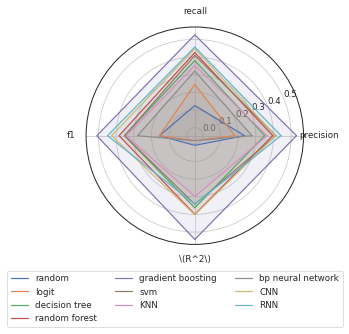

In [15]:
feature = ["precision", "recall", "f1", "\(R^2\)"]
[["model"] + feature] + list(
    [i[0]] + [round(j, 4) for j in i[1].values()] for i in result.items()
)

N = len(feature)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
for model in result:
    values = [i for i in result[model].values()] + [result[model]["precision"]]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)
ax.set_thetagrids(angles[:-1] * 180 / np.pi, feature)
ax.grid(True)
plt.legend(bbox_to_anchor=(1.2, -0.1), ncol=3)
plt.show()
